<IPython.core.display.Javascript object>


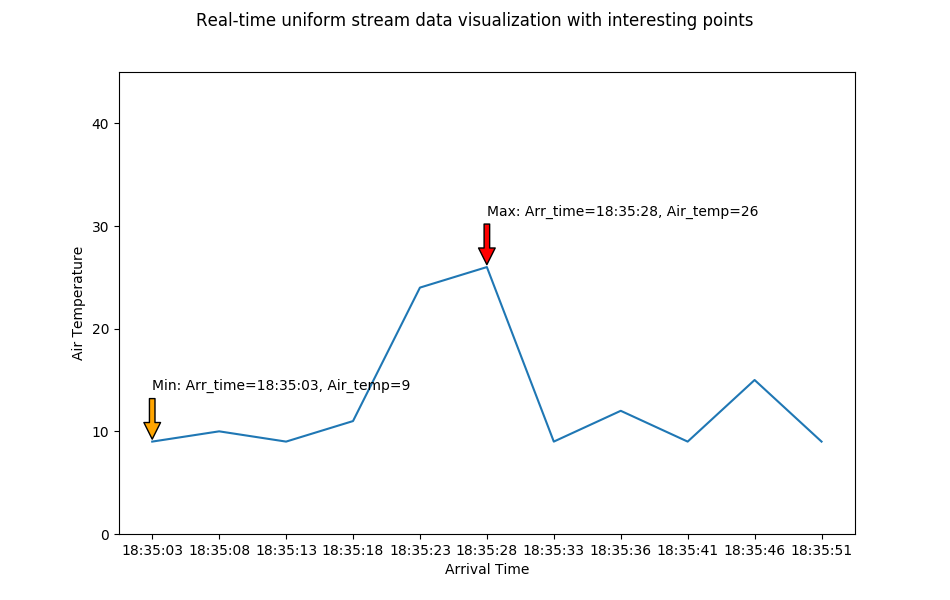

In [ ]:
# import statements
from time import sleep
import json
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'fire'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Arr_time={}, Air_temp={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Arr_time={}, Air_temp={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['127.0.0.1:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,45) 
        ax.set_yticks([0,10,20,30,40])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = message.value.decode('ascii')
            temp = json.loads(data)
            
            x.append(temp['created_time']) 
            y.append(int(temp['air_temperature_celcius']))
            
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0,45) 
                ax.set_yticks([0,10,20,30,40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
      
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

In [ ]:
import matplotlib.pyplot as plt #import library for plotting
# This following magic line is to make sure graph shown inline of the notebook
%matplotlib inline
import numpy as np
import csv
from pprint import pprint
from pymongo import MongoClient

def plot_bar(time, count):
    ind = np.arange(0, 10, 2) # 10 bars in total with 2 as interval
    width = 0.5               # the width of the bars
    fig, ax = plt.subplots()

    # Insert data into the rect  #
    # The input should be a list of {"time": xxx, "number of fires": xxx}
    rect = ax.bar(ind, count, width, color='g')
    ax.set_ylabel('The Number of Fires')  # add some text for labels, title and axes ticks
    ax.set_title('Top 10 hotspots with most fires')
    ax.set_xsticklabels(time)
    ax.set_xticks(ind + width+0.1)
    # Add the list of time with length of 10 below between the # #
    #ax.set_xticklabels(#LIST_OF_TIME# ,rotation='vertical')
    ax.legend(('count'))
    fig.set_size_inches(18.5, 10.5)
    


mongo_client = MongoClient()
db=mongo_client.fit5148_assignment_db
hotspot = db.hotspot_historic

number = 0
time =[]
count = []

sort_time = hotspot.find().sort('current_time',-1)

for document in sort_time:
    time_string = datetime.striptime(document['current_time'])
    time = datetime.strptime(time_string, '%H.%M.%S')
    if time.length == 10:
        break
    
    else:
        if time.length == 0: 
            time.append(time_string)
            number += 1
       
        else:
            time_before = datetime.strptime(time[-1], '%H.%M.%S')
            seconds_off = (time - time_before).seconds
            minutes_off = round(seconds_off/60,1)
       
            if minutes_off <= 5:
                number = number + 1           
            else:
                count.append(number)
                number = 1
                time.append(time_string)

plot_bar(time, count)

In [ ]:
!pip3 install gmplot

gmap = gmplot.GoogleMapPlotter(-37.966,145.051, 15) # latitude and longitude of the first hotspot

In [ ]:
import gmplot
import Geohash as gh
from pymongo import MongoClient

client = MongoClient() 
db = client.fit5148_assignment_db
climate = db.cli
hotspot = db.isfire 

# Preparing the data for plotting
unoccupiedList = []
surface_temp = 0  
air_temp = 0
relative_humidity = 0
confidence = 0
info = ""


# Looping through all the data
for row in hotspot.find():  #latitude geo hash
    geo_hotspot = hotspot['geo']  
    unoccupiedList.append((float(row['latitude']), float(row['longitude'])))
    
    # Add text label
    confidence = row['confidence']
    surface_temp = row['surface_temperature']    
    climate_record = db.climate_historic.find_one({"geo": geo_hotspot})
    air_temp = climate_record['air_temperature']     
    relative_humidity = climate_record['relative humidity']
    info = "surface_temp: " + surface_temp + "confidence: " + confidence + "air_temp: " + air_temp + "relative humidity:" + relative_humidity
    #Display info
    gmap.marker(float(row['latitude']), float(row['longitude']), title = info)
    